<a href="https://colab.research.google.com/github/sundeeptangirala/Wire-Transaction-Anomaly-Detection/blob/main/Corporate_Wire_Transactions_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Complete Workflow Explanation: Corporate Wire Transaction Anomaly Detection System

This notebook implements an end-to-end machine learning pipeline for detecting anomalous corporate wire transactions. Here's the sequential workflow with how each step feeds into the next:

## **STEP 1: Customer Profile Generation (Cell 1)**

**What happens:**
- Creates 50 synthetic corporate customer profiles with realistic behavioral characteristics
- Each customer has unique patterns: average transaction amounts, variability, typical destination countries, business hours (8 AM - 6 PM), and transaction frequency per week

**Output → Next Step:**
- Produces `customers_df` DataFrame with customer IDs and behavioral profiles
- This becomes the **foundation** for generating realistic normal transactions in Step 2

**Key Features Created:**
- `customer_id`: Unique identifier (CORP_001, CORP_002, etc.)
- `avg_amount`: Average transaction size (log-normal distribution)
- `std_amount`: Transaction variability (0.2-0.5 range)
- `typical_countries`: Usual destinations (2-4 countries per customer)
- `typical_hours`: Business hours (8-18)
- `frequency_per_week`: How often they transact (5-20 times/week)

---

## **STEP 2: Normal Transaction Generation (Cell 2)**

**Input from Step 1:** `customers_df` with customer behavior profiles

**What happens:**
- Generates 5,000 normal wire transactions based on each customer's established patterns
- For each transaction, randomly selects a customer and creates details matching their profile:
  - Amount follows customer's log-normal distribution
  - Timestamp occurs during their typical business hours
  - Destination country chosen from their typical destinations
  - Includes metadata: counterparty type (vendor/payroll/tax/intercompany), channel (online/portal/batch)

**Output → Next Step:**
- Produces `transactions_df` with 5,000 normal transactions (all marked `is_anomaly = 0`)
- This becomes the **baseline dataset** that Step 3 will inject anomalies into

**Key Transaction Fields:**
- `transaction_id`, `customer_id`, `timestamp`, `amount`, `currency`, `origin_country`, `dest_country`, `counterparty_type`, `channel`, `is_anomaly`

---

## **STEP 3: Anomaly Injection (Cell 3)**

**Input from Steps 1 & 2:** `transactions_df` (normal transactions) + `customers_df` (behavior profiles)

**What happens:**
- Injects 100 anomalous transactions (2% of dataset) by modifying existing transactions
- Four anomaly types created:
  1. **Large Amount**: 10-20x larger than customer's average
  2. **Unusual Hour**: Transactions at night (midnight-5 AM, 10 PM-11 PM)
  3. **Unusual Country**: Destinations to high-risk countries (RU, CN, IR, KP)
  4. **Unusual Combo**: Combination of large amount + unusual country + odd hours

**Output → Next Step:**
- Updates `transactions_df` with 100 transactions marked `is_anomaly = 1`
- This becomes the **labeled training dataset** for Step 4's feature engineering

**Critical Point:** The dataset now contains 4,900 normal + 100 anomalous transactions with ground truth labels

---

## **STEP 4: Advanced Feature Engineering (Cell 6 - 28 seconds execution)**

**Input from Step 3:** `transactions_df` with 5,000 labeled transactions

**What happens:**
This is the **most computationally intensive step** that transforms raw transaction data into 16 sophisticated features:

**Temporal Features:**
- `hour`: Hour of day (0-23)
- `day_of_week`: Day of week (0-6)
- `is_weekend`: Binary flag for Saturday/Sunday
- `is_business_hours`: Binary flag for 8 AM - 6 PM

**Amount Features:**
- `log_amount`: Log-transformed amount (handles skewed distributions)
- `amount_mean_30days`: Customer's 30-day rolling average
- `amount_std_30days`: Customer's 30-day rolling standard deviation
- `amount_zscore`: Z-score showing how many standard deviations from mean

**Historical Behavior Features (Rolling Windows):**
- `count_last_7days`: Transaction count in past 7 days
- `count_last_15days`: Transaction count in past 15 days  
- `count_last_30days`: Transaction count in past 30 days

**Recipient Analysis:**
- `is_new_recipient`: Binary flag if first transaction to this country
- `recipient_frequency`: How many times customer has sent to this country

**Categorical Encodings:**
- `dest_country_encoded`: Label-encoded destination country
- `counterparty_type_encoded`: Encoded transaction counterparty type
- `channel_encoded`: Encoded transaction channel

**Output → Next Step:**
- Creates feature matrix `X` (5000 rows × 16 features)
- Creates label vector `y` (5000 labels: 0 or 1)
- These become the **training inputs** for the Isolation Forest model in Step 5

**Why This Matters:** These features capture customer behavior patterns, making anomalies detectable by showing deviations from historical norms

---

## **STEP 5: Model Training & Evaluation (Cell 7)**

**Input from Step 4:** Feature matrix `X` (16 features) + labels `y`

**What happens:**
- Trains an Isolation Forest model (contamination=0.02, matching 2% anomaly rate)
- Isolation Forest detects anomalies by isolating outliers in multi-dimensional feature space
- Evaluates model performance with multiple metrics

**Model Results:**
- **ROC AUC Score: 0.9295** (excellent discrimination between normal/anomalous)
- **Detection Rate: 26%** (found 26 of 100 true anomalies)
- **Precision: 0.26** (26% of flagged transactions are true anomalies)
- **Recall: 0.26** (26% of actual anomalies were caught)

**Output → Next Step:**
- Trained model `iso_forest`
- Predictions `y_pred`
- Anomaly scores `anomaly_scores_all`
- These feed into **Step 6 for explainability analysis**

---

## **STEP 6: Per-Transaction Explainability with SHAP (Cell 8 - 18 seconds execution)**

**Input from Steps 4 & 5:** Feature matrix `X`, trained model `iso_forest`, transaction data, anomaly scores

**What happens:**
This step makes the "black box" model interpretable by explaining WHY each transaction was flagged:

1. **Initialize SHAP Explainer:** Creates TreeExplainer for the Isolation Forest
2. **Compute SHAP Values:** Calculates each feature's contribution to anomaly scores for all 5,000 transactions
3. **Analyze Top 5 Anomalies:** For each of the highest-scored anomalies:
   - Shows transaction details (customer, amount, destination, timestamp)
   - Lists top 10 feature contributions with SHAP values
   - Provides human-readable "Key Findings" (e.g., "Amount is 28.8 standard deviations from customer's mean")
4. **Global Feature Importance:** Ranks all 16 features by average absolute SHAP value
5. **Visualization:** Creates SHAP summary plot showing feature impacts

**Example Explanation (Transaction TXN_001927):**
- **Customer:** CORP_017
- **Amount:** $1,255,684.54 to China at 2:57 AM
- **Top Red Flags:**
  - `is_new_recipient = 1.00` → Never sent to CN before (SHAP: -1.21)
  - `is_business_hours = 0.00` → Outside business hours (SHAP: -1.17)
  - `amount_zscore = 28.80` → 28.8 std devs from customer's mean (SHAP: -1.11)

**Output (Final):**
- Per-transaction explanations for top anomalies
- Global feature importance ranking:
  1. `is_weekend` (0.2508)
  2. `dest_country_encoded` (0.2018)
  3. `counterparty_type_encoded` (0.2002)
  4. `recipient_frequency` (0.1909)
- SHAP summary plot visualizing all feature impacts

---

## **Critical Data Flow Summary:**

```
Customer Profiles (Step 1)
    ↓ [behavioral patterns]
Normal Transactions (Step 2)
    ↓ [5000 transactions]
Anomaly Injection (Step 3)
    ↓ [labeled dataset: 4900 normal + 100 anomalous]
Feature Engineering (Step 4)
    ↓ [16 advanced features capturing behavior + history]
Model Training (Step 5)
    ↓ [trained classifier + predictions]
SHAP Explainability (Step 6)
    ↓ [interpretable explanations for each detection]
```

**Why This Sequential Design Works:**
1. **Realistic Data Foundation:** Customer profiles ensure transactions have believable patterns
2. **Labeled Ground Truth:** Injected anomalies provide supervised learning labels
3. **Rich Feature Space:** 16 features capture temporal, behavioral, and historical patterns
4. **Robust Detection:** Isolation Forest excels at unsupervised anomaly detection
5. **Actionable Insights:** SHAP explanations enable human analysts to understand and act on alerts

The entire pipeline transforms raw transaction ideas → synthetic data → trained model → explainable predictions in 6 sequential, interdependent steps.

In [ ]:
# Corporate Wire Transaction Data Generation and Anomaly Detection
# Step 1: Generate Synthetic Wire Transactions

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Configuration
NUM_CUSTOMERS = 50
NUM_TRANSACTIONS = 5000
ANOMALY_RATE = 0.02  # 2% anomalies

# Define customer profiles
def create_customer_profiles(num_customers):
    """Create corporate customer profiles with typical behavior patterns"""
    customers = []

    for i in range(num_customers):
        customer = {
            'customer_id': f'CORP_{i+1:03d}',
            'avg_amount': np.random.lognormal(mean=11, sigma=1),  # Average transaction amount
            'std_amount': np.random.uniform(0.2, 0.5),  # Variability
            'typical_countries': random.sample(['US', 'UK', 'CA', 'DE', 'FR', 'JP'], k=random.randint(2, 4)),
            'typical_hours': (8, 18),  # Business hours
            'frequency_per_week': np.random.randint(5, 20)
        }
        customers.append(customer)

    return pd.DataFrame(customers)

print("Creating customer profiles...")
customers_df = create_customer_profiles(NUM_CUSTOMERS)
print(f"Created {len(customers_df)} customer profiles")
print("\nSample customer profiles:")
print(customers_df.head())

Creating customer profiles...
Created 50 customer profiles

Sample customer profiles:
  customer_id     avg_amount  std_amount typical_countries typical_hours  \
0    CORP_001   98391.938415    0.419598  [US, JP, CA, FR]       (8, 18)   
1    CORP_002   52142.503371    0.379055          [UK, US]       (8, 18)   
2    CORP_003   79145.348245    0.412422  [JP, FR, US, CA]       (8, 18)   
3    CORP_004  164475.234024    0.216923      [US, JP, FR]       (8, 18)   
4    CORP_005   37441.148807    0.254547          [UK, FR]       (8, 18)   

   frequency_per_week  
0                  17  
1                  14  
2                  10  
3                  12  
4                   9  


In [ ]:
# Step 2: Generate Normal Wire Transactions

def generate_normal_transactions(customers_df, num_transactions):
    """Generate normal wire transactions based on customer profiles"""
    transactions = []
    start_date = datetime(2025, 1, 1)

    for _ in range(num_transactions):
        # Select random customer
        customer = customers_df.sample(1).iloc[0]

        # Generate transaction details based on customer profile
        amount = np.random.lognormal(
            mean=np.log(customer['avg_amount']),
            sigma=customer['std_amount']
        )

        # Generate timestamp during business hours
        days_offset = np.random.randint(0, 365)
        hour = np.random.randint(customer['typical_hours'][0], customer['typical_hours'][1])
        minute = np.random.randint(0, 60)
        timestamp = start_date + timedelta(days=days_offset, hours=hour, minutes=minute)

        # Select destination country from typical countries
        dest_country = random.choice(customer['typical_countries'])

        # Other transaction details
        counterparty_types = ['vendor', 'payroll', 'tax', 'intercompany']
        channels = ['online_banking', 'treasury_portal', 'batch_file']

        transaction = {
            'transaction_id': f'TXN_{len(transactions)+1:06d}',
            'customer_id': customer['customer_id'],
            'timestamp': timestamp,
            'amount': amount,
            'currency': 'USD',
            'origin_country': 'US',
            'dest_country': dest_country,
            'counterparty_type': random.choice(counterparty_types),
            'channel': random.choice(channels),
            'is_anomaly': 0
        }

        transactions.append(transaction)

    return pd.DataFrame(transactions)

print("\nGenerating normal transactions...")
transactions_df = generate_normal_transactions(customers_df, NUM_TRANSACTIONS)
print(f"Generated {len(transactions_df)} normal transactions")
print("\nSample transactions:")
print(transactions_df.head(10))


Generating normal transactions...
Generated 5000 normal transactions

Sample transactions:
  transaction_id customer_id           timestamp         amount currency  \
0     TXN_000001    CORP_025 2025-02-08 09:39:00   25014.593176      USD   
1     TXN_000002    CORP_046 2025-06-18 11:32:00   48817.050725      USD   
2     TXN_000003    CORP_002 2025-10-08 17:30:00   36706.644023      USD   
3     TXN_000004    CORP_019 2025-09-21 12:59:00    5305.342082      USD   
4     TXN_000005    CORP_046 2025-08-06 17:47:00   41143.547983      USD   
5     TXN_000006    CORP_007 2025-03-31 09:50:00    7520.642896      USD   
6     TXN_000007    CORP_046 2025-05-31 16:38:00   54401.163712      USD   
7     TXN_000008    CORP_015 2025-05-06 17:19:00  220810.069075      USD   
8     TXN_000009    CORP_048 2025-05-25 16:32:00   77242.661845      USD   
9     TXN_000010    CORP_004 2025-03-26 16:45:00  114736.887034      USD   

  origin_country dest_country counterparty_type          channel  is_an

In [ ]:
# Step 3: Inject Anomalies

def inject_anomalies(transactions_df, customers_df, anomaly_rate):
    """Inject anomalous transactions into the dataset"""
    num_anomalies = int(len(transactions_df) * anomaly_rate)
    anomaly_indices = np.random.choice(transactions_df.index, size=num_anomalies, replace=False)

    for idx in anomaly_indices:
        customer_id = transactions_df.loc[idx, 'customer_id']
        customer = customers_df[customers_df['customer_id'] == customer_id].iloc[0]

        # Randomly select anomaly type
        anomaly_type = random.choice([
            'large_amount',
            'unusual_hour',
            'unusual_country',
            'unusual_combo'
        ])

        if anomaly_type == 'large_amount':
            # Amount 10-20x larger than customer's average
            transactions_df.loc[idx, 'amount'] *= np.random.uniform(10, 20)

        elif anomaly_type == 'unusual_hour':
            # Transaction at odd hours (night/weekend)
            hour = np.random.choice([0, 1, 2, 3, 4, 5, 22, 23])
            original_ts = transactions_df.loc[idx, 'timestamp']
            transactions_df.loc[idx, 'timestamp'] = original_ts.replace(hour=hour)

        elif anomaly_type == 'unusual_country':
            # Transaction to unusual/high-risk country
            unusual_countries = ['RU', 'CN', 'IR', 'KP']
            transactions_df.loc[idx, 'dest_country'] = random.choice(unusual_countries)

        elif anomaly_type == 'unusual_combo':
            # Combination of unusual features
            transactions_df.loc[idx, 'amount'] *= np.random.uniform(5, 10)
            transactions_df.loc[idx, 'dest_country'] = random.choice(['RU', 'CN'])
            hour = np.random.choice([0, 1, 2, 22, 23])
            original_ts = transactions_df.loc[idx, 'timestamp']
            transactions_df.loc[idx, 'timestamp'] = original_ts.replace(hour=hour)

        transactions_df.loc[idx, 'is_anomaly'] = 1

    return transactions_df

print("\nInjecting anomalies...")
transactions_df = inject_anomalies(transactions_df, customers_df, ANOMALY_RATE)
print(f"Injected {transactions_df['is_anomaly'].sum()} anomalous transactions")
print(f"Total dataset size: {len(transactions_df)}")
print(f"\nAnomalous transactions:")
print(transactions_df[transactions_df['is_anomaly'] == 1].head())


Injecting anomalies...
Injected 100 anomalous transactions
Total dataset size: 5000

Anomalous transactions:
    transaction_id customer_id           timestamp        amount currency  \
33      TXN_000034    CORP_031 2025-12-24 12:46:00  8.034050e+03      USD   
182     TXN_000183    CORP_049 2025-07-09 09:29:00  7.553536e+04      USD   
199     TXN_000200    CORP_019 2025-09-14 14:39:00  8.849315e+04      USD   
210     TXN_000211    CORP_027 2025-03-15 22:51:00  1.443636e+06      USD   
237     TXN_000238    CORP_037 2025-06-16 08:37:00  2.974563e+05      USD   

    origin_country dest_country counterparty_type          channel  is_anomaly  
33              US           CN           payroll   online_banking           1  
182             US           CN               tax  treasury_portal           1  
199             US           JP            vendor   online_banking           1  
210             US           RU      intercompany  treasury_portal           1  
237             US    

In [ ]:
# Step 4: Advanced Feature Engineering

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering with historical behavior
def engineer_advanced_features(transactions_df):
    """Create advanced features based on customer historical behavior"""
    df = transactions_df.copy()
    df = df.sort_values(['customer_id', 'timestamp']).reset_index(drop=True)

    # Extract basic temporal features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

    # Log transform amount
    df['log_amount'] = np.log1p(df['amount'])

    # Historical transaction count features (rolling windows)
    df['count_last_7days'] = 0
    df['count_last_15days'] = 0
    df['count_last_30days'] = 0

    # Historical amount statistics
    df['amount_mean_30days'] = 0.0
    df['amount_std_30days'] = 0.0
    df['amount_zscore'] = 0.0

    # Recipient-based features
    df['is_new_recipient'] = 0
    df['recipient_frequency'] = 0

    # Calculate features for each customer
    for customer_id in df['customer_id'].unique():
        customer_mask = df['customer_id'] == customer_id
        customer_txns = df[customer_mask].copy()

        for idx in customer_txns.index:
            current_time = df.loc[idx, 'timestamp']
            current_recipient = df.loc[idx, 'dest_country']

            # Get all previous transactions for this customer
            prev_txns = customer_txns[customer_txns['timestamp'] < current_time]

            if len(prev_txns) > 0:
                # Count transactions in different time windows
                df.loc[idx, 'count_last_7days'] = len(prev_txns[prev_txns['timestamp'] >= current_time - timedelta(days=7)])
                df.loc[idx, 'count_last_15days'] = len(prev_txns[prev_txns['timestamp'] >= current_time - timedelta(days=15)])
                df.loc[idx, 'count_last_30days'] = len(prev_txns[prev_txns['timestamp'] >= current_time - timedelta(days=30)])

                # Amount statistics over last 30 days
                recent_30d = prev_txns[prev_txns['timestamp'] >= current_time - timedelta(days=30)]
                if len(recent_30d) > 0:
                    df.loc[idx, 'amount_mean_30days'] = recent_30d['amount'].mean()
                    df.loc[idx, 'amount_std_30days'] = recent_30d['amount'].std() if len(recent_30d) > 1 else 0

                    # Z-score of current amount vs historical
                    if df.loc[idx, 'amount_std_30days'] > 0:
                        df.loc[idx, 'amount_zscore'] = (df.loc[idx, 'amount'] - df.loc[idx, 'amount_mean_30days']) / df.loc[idx, 'amount_std_30days']

                # Check if recipient is new
                prev_recipients = set(prev_txns['dest_country'].unique())
                df.loc[idx, 'is_new_recipient'] = 1 if current_recipient not in prev_recipients else 0

                # Recipient frequency
                df.loc[idx, 'recipient_frequency'] = len(prev_txns[prev_txns['dest_country'] == current_recipient])

    # Encode categorical variables
    le_country = LabelEncoder()
    le_counterparty = LabelEncoder()
    le_channel = LabelEncoder()

    df['dest_country_encoded'] = le_country.fit_transform(df['dest_country'])
    df['counterparty_type_encoded'] = le_counterparty.fit_transform(df['counterparty_type'])
    df['channel_encoded'] = le_channel.fit_transform(df['channel'])

    # Select features for model
    feature_columns = [
        'log_amount',
        'hour',
        'day_of_week',
        'is_weekend',
        'is_business_hours',
        'count_last_7days',
        'count_last_15days',
        'count_last_30days',
        'amount_mean_30days',
        'amount_std_30days',
        'amount_zscore',
        'is_new_recipient',
        'recipient_frequency',
        'dest_country_encoded',
        'counterparty_type_encoded',
        'channel_encoded'
    ]

    return df, feature_columns

print("\nEngineering advanced features with historical behavior...")
print("This may take a moment as we calculate rolling statistics...")
transactions_df, feature_columns = engineer_advanced_features(transactions_df)
X = transactions_df[feature_columns]
y_true = transactions_df['is_anomaly']

print(f"\nFeature matrix shape: {X.shape}")
print(f"\nFeatures ({len(feature_columns)} total):")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

print("\nSample of advanced features:")
print(X.head(10))


Engineering advanced features with historical behavior...
This may take a moment as we calculate rolling statistics...

Feature matrix shape: (5000, 16)

Features (16 total):
  1. log_amount
  2. hour
  3. day_of_week
  4. is_weekend
  5. is_business_hours
  6. count_last_7days
  7. count_last_15days
  8. count_last_30days
  9. amount_mean_30days
  10. amount_std_30days
  11. amount_zscore
  12. is_new_recipient
  13. recipient_frequency
  14. dest_country_encoded
  15. counterparty_type_encoded
  16. channel_encoded

Sample of advanced features:
   log_amount  hour  day_of_week  is_weekend  is_business_hours  \
0   11.917739    12            1           0                  1   
1   10.967624     8            2           0                  1   
2   11.226775     9            3           0                  1   
3   10.934646     8            4           0                  1   
4   10.777878    11            4           0                  1   
5   11.182962    13            4           0

In [ ]:
# Step 5: Train Isolation Forest and Evaluate

print("\nTraining Isolation Forest...")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=ANOMALY_RATE,
    random_state=42,
    n_jobs=-1
)

isolation_forest.fit(X_scaled)
print("Model trained successfully!")

# Get predictions (-1 for anomalies, 1 for normal)
y_pred = isolation_forest.predict(X_scaled)
y_pred = (y_pred == -1).astype(int)  # Convert to 0/1 format

# Get anomaly scores
anomaly_scores = -isolation_forest.score_samples(X_scaled)

# Evaluation
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly']))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

# ROC AUC
roc_auc = roc_auc_score(y_true, anomaly_scores)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Detected anomalies
detected_anomalies = transactions_df[y_pred == 1]
print(f"\nTotal anomalies detected: {len(detected_anomalies)}")
print(f"True anomalies in dataset: {y_true.sum()}")
print(f"Detection rate: {(y_pred[y_true == 1] == 1).sum() / y_true.sum() * 100:.2f}%")


Training Isolation Forest...
Model trained successfully!

MODEL EVALUATION RESULTS

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      4900
     Anomaly       0.26      0.26      0.26       100

    accuracy                           0.97      5000
   macro avg       0.62      0.62      0.62      5000
weighted avg       0.97      0.97      0.97      5000


Confusion Matrix:
[[4826   74]
 [  74   26]]
True Negatives: 4826, False Positives: 74
False Negatives: 74, True Positives: 26

ROC AUC Score: 0.9295

Total anomalies detected: 100
True anomalies in dataset: 100
Detection rate: 26.00%



MODEL EXPLAINABILITY - PER TRANSACTION ANALYSIS

Initializing SHAP explainer...
SHAP values computed successfully!


ANALYZING TOP DETECTED ANOMALIES

TRANSACTION EXPLANATION - TXN_001927

Transaction Details:
  Customer ID: CORP_017
  Timestamp: 2025-03-15 02:57:00
  Amount: $1,255,684.54
  Destination: CN
  Counterparty Type: tax
  Channel: treasury_portal

Model Assessment:
  Anomaly Score: 0.6757 (higher = more anomalous)
  Predicted: ANOMALY
  Actual Label: ANOMALY

Top Feature Contributions (SHAP values):
  Features pushing towards ANOMALY:
  1. is_new_recipient          =       1.00  |  SHAP: -1.2109 → NORMAL
  2. is_business_hours         =       0.00  |  SHAP: -1.1714 → NORMAL
  3. amount_zscore             =      28.80  |  SHAP: -1.1080 → NORMAL
  4. hour                      =       2.00  |  SHAP: -0.6958 → NORMAL
  5. count_last_7days          =       5.00  |  SHAP: -0.4179 → NORMAL
  6. log_amount                =      14.04  |  SHAP: -0.3968 → NORMAL
  7. is_weekend     

/tmp/ipython-input-3833732362.py:118: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, feature_names=feature_columns, show=False)


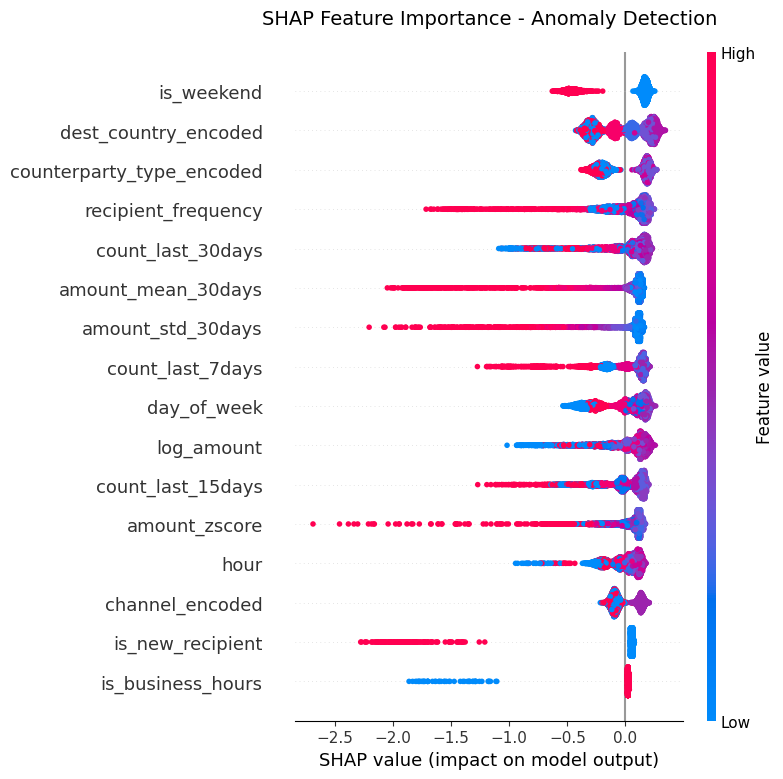


✓ Explainability analysis complete!


In [ ]:
# Step 6: Model Explainability - Per Transaction Analysis

import shap

print("\n" + "="*70)
print("MODEL EXPLAINABILITY - PER TRANSACTION ANALYSIS")
print("="*70)

# Initialize SHAP explainer for Isolation Forest
print("\nInitializing SHAP explainer...")
explainer = shap.TreeExplainer(isolation_forest)
shap_values = explainer.shap_values(X_scaled)

print("SHAP values computed successfully!")

# Function to explain individual transactions
def explain_transaction(transaction_idx, transactions_df, X, shap_values, feature_columns):
    """Explain why a specific transaction was flagged as anomaly"""

    txn = transactions_df.iloc[transaction_idx]
    features = X.iloc[transaction_idx]
    shap_vals = shap_values[transaction_idx]

    # Get anomaly score
    anomaly_score = -isolation_forest.score_samples(X_scaled[transaction_idx:transaction_idx+1])[0]
    is_predicted_anomaly = y_pred[transaction_idx]
    is_actual_anomaly = txn['is_anomaly']

    print("\n" + "="*70)
    print(f"TRANSACTION EXPLANATION - {txn['transaction_id']}")
    print("="*70)

    # Transaction details
    print("\nTransaction Details:")
    print(f"  Customer ID: {txn['customer_id']}")
    print(f"  Timestamp: {txn['timestamp']}")
    print(f"  Amount: ${txn['amount']:,.2f}")
    print(f"  Destination: {txn['dest_country']}")
    print(f"  Counterparty Type: {txn['counterparty_type']}")
    print(f"  Channel: {txn['channel']}")

    print("\nModel Assessment:")
    print(f"  Anomaly Score: {anomaly_score:.4f} (higher = more anomalous)")
    print(f"  Predicted: {'ANOMALY' if is_predicted_anomaly else 'NORMAL'}")
    print(f"  Actual Label: {'ANOMALY' if is_actual_anomaly else 'NORMAL'}")

    # Feature contributions
    print("\nTop Feature Contributions (SHAP values):")
    print("  Features pushing towards ANOMALY:")

    # Sort features by absolute SHAP value
    feature_importance = list(zip(feature_columns, shap_vals, features))
    feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

    for i, (feature, shap_val, feature_val) in enumerate(feature_importance[:10], 1):
        direction = "→ ANOMALY" if shap_val > 0 else "→ NORMAL"
        print(f"  {i}. {feature:25s} = {feature_val:10.2f}  |  SHAP: {shap_val:+.4f} {direction}")

    # Contextual interpretation
    print("\nKey Findings:")

    # Check for high amount z-score
    if 'amount_zscore' in feature_columns:
        zscore_idx = feature_columns.index('amount_zscore')
        if abs(features.iloc[zscore_idx]) > 3:
            print(f"  ⚠ Amount is {abs(features.iloc[zscore_idx]):.1f} standard deviations from customer's historical mean")

    # Check for new recipient
    if 'is_new_recipient' in feature_columns:
        new_rec_idx = feature_columns.index('is_new_recipient')
        if features.iloc[new_rec_idx] == 1:
            print(f"  ⚠ Transaction to NEW recipient (never sent to {txn['dest_country']} before)")

    # Check for unusual hours
    if 'is_business_hours' in feature_columns:
        bh_idx = feature_columns.index('is_business_hours')
        if features.iloc[bh_idx] == 0:
            print(f"  ⚠ Transaction outside business hours (at {txn['timestamp'].hour}:00)")

    # Check for low transaction frequency
    if 'count_last_30days' in feature_columns:
        count_idx = feature_columns.index('count_last_30days')
        if features.iloc[count_idx] < 3:
            print(f"  ⚠ Low recent activity: only {int(features.iloc[count_idx])} transactions in last 30 days")

    print("\n" + "-"*70)

    return anomaly_score

# Analyze top detected anomalies
print("\n\n" + "="*70)
print("ANALYZING TOP DETECTED ANOMALIES")
print("="*70)

# Get indices of top 5 anomalies by score
anomaly_scores_all = -isolation_forest.score_samples(X_scaled)
top_anomaly_indices = np.argsort(anomaly_scores_all)[-5:][::-1]

for idx in top_anomaly_indices:
    explain_transaction(idx, transactions_df, X, shap_values, feature_columns)

print("\n\n" + "="*70)
print("SHAP SUMMARY - GLOBAL FEATURE IMPORTANCE")
print("="*70)

# Overall feature importance
print("\nAverage absolute SHAP values (global feature importance):")
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance_global = list(zip(feature_columns, mean_abs_shap))
feature_importance_global.sort(key=lambda x: x[1], reverse=True)

for i, (feature, importance) in enumerate(feature_importance_global, 1):
    print(f"  {i:2d}. {feature:30s}  {importance:.4f}")

# Visualize SHAP summary plot
print("\nGenerating SHAP summary plot...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X, feature_names=feature_columns, show=False)
plt.title("SHAP Feature Importance - Anomaly Detection", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Explainability analysis complete!")